In [1]:
# !! NEVER EVER NEVER TURN THIS FUCKING AUTORELOAD ON. IT FUCKS UP JAX !!
# %load_ext autoreload
# %autoreload 2

In [1]:
import os
import random
import h5py
import math
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import fenton_karma as fk

## General simulations setup
This guarantees to have the same shape and samedx and dt

In [ ]:
# simulation inputs (real values)
root = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/"
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = fk.params.params3()

# infinitesimals
dx = 0.01  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

# diffusivity 
d = 0.001  # cm^2/ms
shape = fk.convert.realsize_to_shape(field_size, dx)
diffusivity = np.ones(shape) * d

## Two linear waves

In [ ]:
name = root + "train_dev_set/spiral_params5.hdf5"

In [ ]:
# times
start = 0  # ms
stop = 2000  # ms

# stimuli
s1 = fk.stimulus.protocol(start=0, duration=2)
s1 = fk.stimulus.triangular(shape, direction="right", angle=15, coverage=0.1, modulus=0.5, protocol=s1)

s2 = fk.stimulus.protocol(start=fk.convert.ms_to_units(400, dt), duration=2)
s2 = fk.stimulus.triangular(shape, direction="up", angle=60, coverage=0.7, modulus=0.5, protocol=s2)

# s3 = fk.stimulus.protocol(start=fk.convert.ms_to_units(900, dt), duration=2)
# s3 = fk.stimulus.triangular(shape, direction="down", angle=30, coverage=0.7, modulus=1., protocol=s3)

stimuli = [s1, s2]
fk.plot.show_stimuli(*stimuli)

In [ ]:
checkpoints = np.arange(0, 200000, 12000)
states = fk.model.forward(shape, checkpoints, cell_parameters, diffusivity, stimuli, dt, dx)

In [ ]:
fk.data.generate(start=fk.convert.ms_to_units(start, dt),
                 stop=fk.convert.ms_to_units(stop, dt),
                 dt=dt, dx=dx,
                 cell_parameters=cell_parameters,
                 diffusivity=diffusivity,
                 stimuli=stimuli,
                 filename=name)

In [ ]:
# display
show_every = 50  # ms
with h5py.File(name, "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

V = fk.convert.u_to_V(states[:, 2])
fig, ax = fk.plot.show_grid(V, figsize=(25, 25), font_size=18)

## Three tailored stimuli

In [ ]:
name = root + "train_dev_set/three_points_params3.hdf5"

In [ ]:
# times
start = 0  # ms
stop = 2000  # ms

# stimuli
centre = fk.convert.realsize_to_shape((2, 2), dx)
size = fk.convert.realsize_to_shape((1, 1), dx)
s1 = fk.stimulus.protocol(start=0, duration=2, period=0)
s1 = fk.stimulus.rectangular(shape, centre, size, .8, s1)

centre = fk.convert.realsize_to_shape((5, 5), dx)
size = fk.convert.realsize_to_shape((1, 1), dx)
s2 = fk.stimulus.protocol(start=fk.convert.ms_to_units(370, dt), duration=2, period=0)
s2 = fk.stimulus.rectangular(shape, centre, size, .8, s2)

centre = fk.convert.realsize_to_shape((8.5, 2.5), dx)
size = fk.convert.realsize_to_shape((1, 1), dx)
s3 = fk.stimulus.protocol(start=fk.convert.ms_to_units(600, dt), duration=2, period=0)
s3 = fk.stimulus.rectangular(shape, centre, size, .8, s3)

centre = fk.convert.realsize_to_shape((8.5, 8.5), dx)
size = fk.convert.realsize_to_shape((1, 1), dx)
s4 = fk.stimulus.protocol(start=fk.convert.ms_to_units(1500, dt), duration=2, period=0)
s4 = fk.stimulus.rectangular(shape, centre, size, .8, s4)

stimuli = [s1, s2, s3, s4]
fk.plot.show_stimuli(*stimuli)

In [ ]:
checkpoints = np.arange(0, 200000, 12000)
fk.model.forward(shape, checkpoints, cell_parameters, diffusivity, stimuli, dt, dx)

In [ ]:
fk.data.generate(start=fk.convert.ms_to_units(start, dt),
                 stop=fk.convert.ms_to_units(stop, dt),
                 dt=dt, dx=dx,
                 cell_parameters=cell_parameters,
                 diffusivity=diffusivity,
                 stimuli=stimuli,
                 filename=name)

In [ ]:
# display
show_every = 100  # ms
with h5py.File(name, "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

V = fk.convert.u_to_V(states[:, 2])
fig, ax = fk.plot.show_grid(V, figsize=(25, 15), times=range(0, len(V) * show_every, show_every))

## Heartbeat + external

In [ ]:
name = root + "train_dev_set/heartbeat_params3.hdf5"

In [ ]:
# times
start = 0  # ms
stop = 2000  # ms

# stimuli
import random
heartbeat = fk.stimulus.protocol(start=0, duration=2, period=fk.convert.ms_to_units(400, dt))
heartbeat = fk.stimulus.random_triangular(shape, 0.5, protocol=heartbeat)

external = fk.stimulus.protocol(start=fk.convert.ms_to_units(300, dt), duration=2,
                               period=fk.convert.ms_to_units(500, dt))
x1 = random.random() * (field_size[0] - 1)
x2 = random.random() * (field_size[1] - 1)
centre = fk.convert.realsize_to_shape((x1, x2), dx)
size = fk.convert.realsize_to_shape((1, 1), dx)
external = fk.stimulus.rectangular(shape, centre, size, 0.5, external)

stimuli = [heartbeat, external]
fk.plot.show_stimuli(*stimuli)

In [ ]:
checkpoints = np.arange(0, 200000, 10000)
fk.model.forward(shape, checkpoints, cell_parameters, diffusivity, stimuli, dt, dx)

In [ ]:
fk.data.generate(start=fk.convert.ms_to_units(start, dt),
                 stop=fk.convert.ms_to_units(stop, dt),
                 dt=dt, dx=dx,
                 cell_parameters=cell_parameters,
                 diffusivity=diffusivity,
                 stimuli=stimuli,
                 filename=name)

In [ ]:
# display
show_every = 100  # ms
with h5py.File(name, "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

fig, ax = fk.plot.show_grid(states[:, 2], figsize=(15, 15))

In [ ]:
name = root + "train_dev_set/heartbeat_params9.hdf5"
# display
show_every = 100  # ms
with h5py.File(name, "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

fig, ax = fk.plot.show_grid(states[:, 2], figsize=(15, 15))

## SEPARATE DIFFUSION AND REACTION TERM

In [2]:
# simulation inputs (real values)
root = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/"
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = fk.params.params3()

# infinitesimals
dx = 0.01  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

# diffusivity 
d = 0.001  # cm^2/ms
shape = fk.convert.realsize_to_shape(field_size, dx)
diffusivity = np.ones(shape) * d

In [3]:
name = root + "train_dev_set/deepreact_spiral_params5.hdf5"

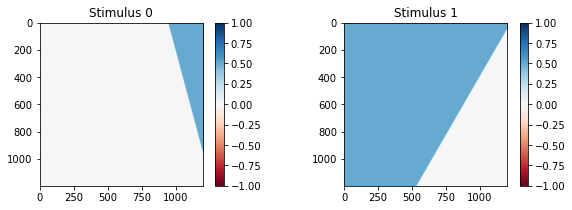

In [4]:
# times
start = 0  # ms
stop = 2000  # ms
show_every = 1  # ms

# stimuli
s1 = fk.stimulus.protocol(start=0, duration=2)
s1 = fk.stimulus.triangular(shape, direction="right", angle=15, coverage=0.1, modulus=0.5, protocol=s1)

s2 = fk.stimulus.protocol(start=fk.convert.ms_to_units(400, dt), duration=2)
s2 = fk.stimulus.triangular(shape, direction="up", angle=60, coverage=0.7, modulus=0.5, protocol=s2)

# s3 = fk.stimulus.protocol(start=fk.convert.ms_to_units(900, dt), duration=2)
# s3 = fk.stimulus.triangular(shape, direction="down", angle=30, coverage=0.7, modulus=1., protocol=s3)

stimuli = [s1, s2]
fk.plot.show_stimuli(*stimuli)

In [5]:
state = fk.model.init(shape)

In [6]:
state = fk.model.step(state, 10, cell_parameters, diffusivity, stimuli, dt, dx)

In [7]:
checkpoints = np.arange(start // dt, (stop - start) // dt, show_every // dt)
states = fk.model.forward(shape, checkpoints, cell_parameters, diffusivity, stimuli, dt, dx)

TypeError: body_fun output and input must have same type structure, got PyTreeDef(tuple, [*,*,*]) and PyTreeDef(tuple, [*,*,PyTreeDef(namedtuple[<class 'fenton_karma.model.State'>], [*,*,*,*,*])]).

In [ ]:
fk.data.generate(start=fk.convert.ms_to_units(start, dt),
                 stop=fk.convert.ms_to_units(stop, dt),
                 dt=dt, dx=dx,
                 cell_parameters=cell_parameters,
                 diffusivity=diffusivity,
                 stimuli=stimuli,
                 filename=name)

In [ ]:
# display
with h5py.File(name, "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

V = fk.convert.u_to_V(states[:, 2])
fig, ax = fk.plot.show_grid(V, figsize=(25, 25), font_size=18)